##Projeto de IIA 4

Sara Queimado 52806
Rodrigo Martins 52790
Diogo Fernandes 52803

Neste projeto, explorámos a aprendizagem automática, a partir das classes DecisionTreeClassifier e KNeighborsClassifier, do módulo sklearn. Para começar, escrevemos os imports:

In [1]:
import numpy
from sklearn.model_selection import *
from sklearn.neighbors import *
from sklearn.tree import *

from utilsAA import *

De seguida, lemos os dados dos dois ficheiros .csv, que contêm os dados relativos aos clientes. A lista raw_data guarda os dados dos clientes que iremos utilizar para a criação das árvores, e a raw_data_t serão os dados que iremos utilizar para testar os nossos modelos.

In [2]:
raw_data = load_data("airline.csv", False)
raw_data_t = load_data("test.csv", True)

Estes dados não estão prontos para ser utilizados. Em primeiro lugar, é necessário apagar a primeira coluna (ID), visto que este dado é irrelevante, e em segundo lugar, é necessário trocar os dados alfabéticos para dados numéricos. Para tal, recorremos à função encode_feature(). Para além disto, separamos as diferentes partes da raw_data e raw_data_t em: features e feature_names, klass e klass_names, e test_features.

In [3]:
def encode_all(data):
    # encode gender
    data[:, 0] = encode_feature(data[:, 0])
    # encode customer type
    data[:, 1] = encode_feature(data[:, 1])
    # encode type of travel
    data[:, 3] = encode_feature((data[:, 3]))
    # encode class
    data[:, 4] = encode_feature(data[:, 4])
    return data

def remove_client_id(data):
    data = data[:, 1:]
    return data

raw_data = (remove_client_id(raw_data[0]),) + raw_data[1:]
features = encode_all(raw_data[0])
klass = raw_data[1]
feature_names = raw_data[2][1:]
klass_names = raw_data[3]
raw_data_t = (remove_client_id(raw_data_t[0]),) + raw_data_t[1:]
test_features = encode_all(raw_data_t[0])



Com os dados tratados e organizados, podemos, então, fazer uma árvore de decisão. Começamos por utilizar a classe DecisionTreeClassifier. Criamos então a árvore, e damos-lhe os dados que irá utilizar com o método fit(). Finalmente, através do método plot_tree(), criamos uma representação visual da árvore.

<function matplotlib.pyplot.show(close=None, block=None)>

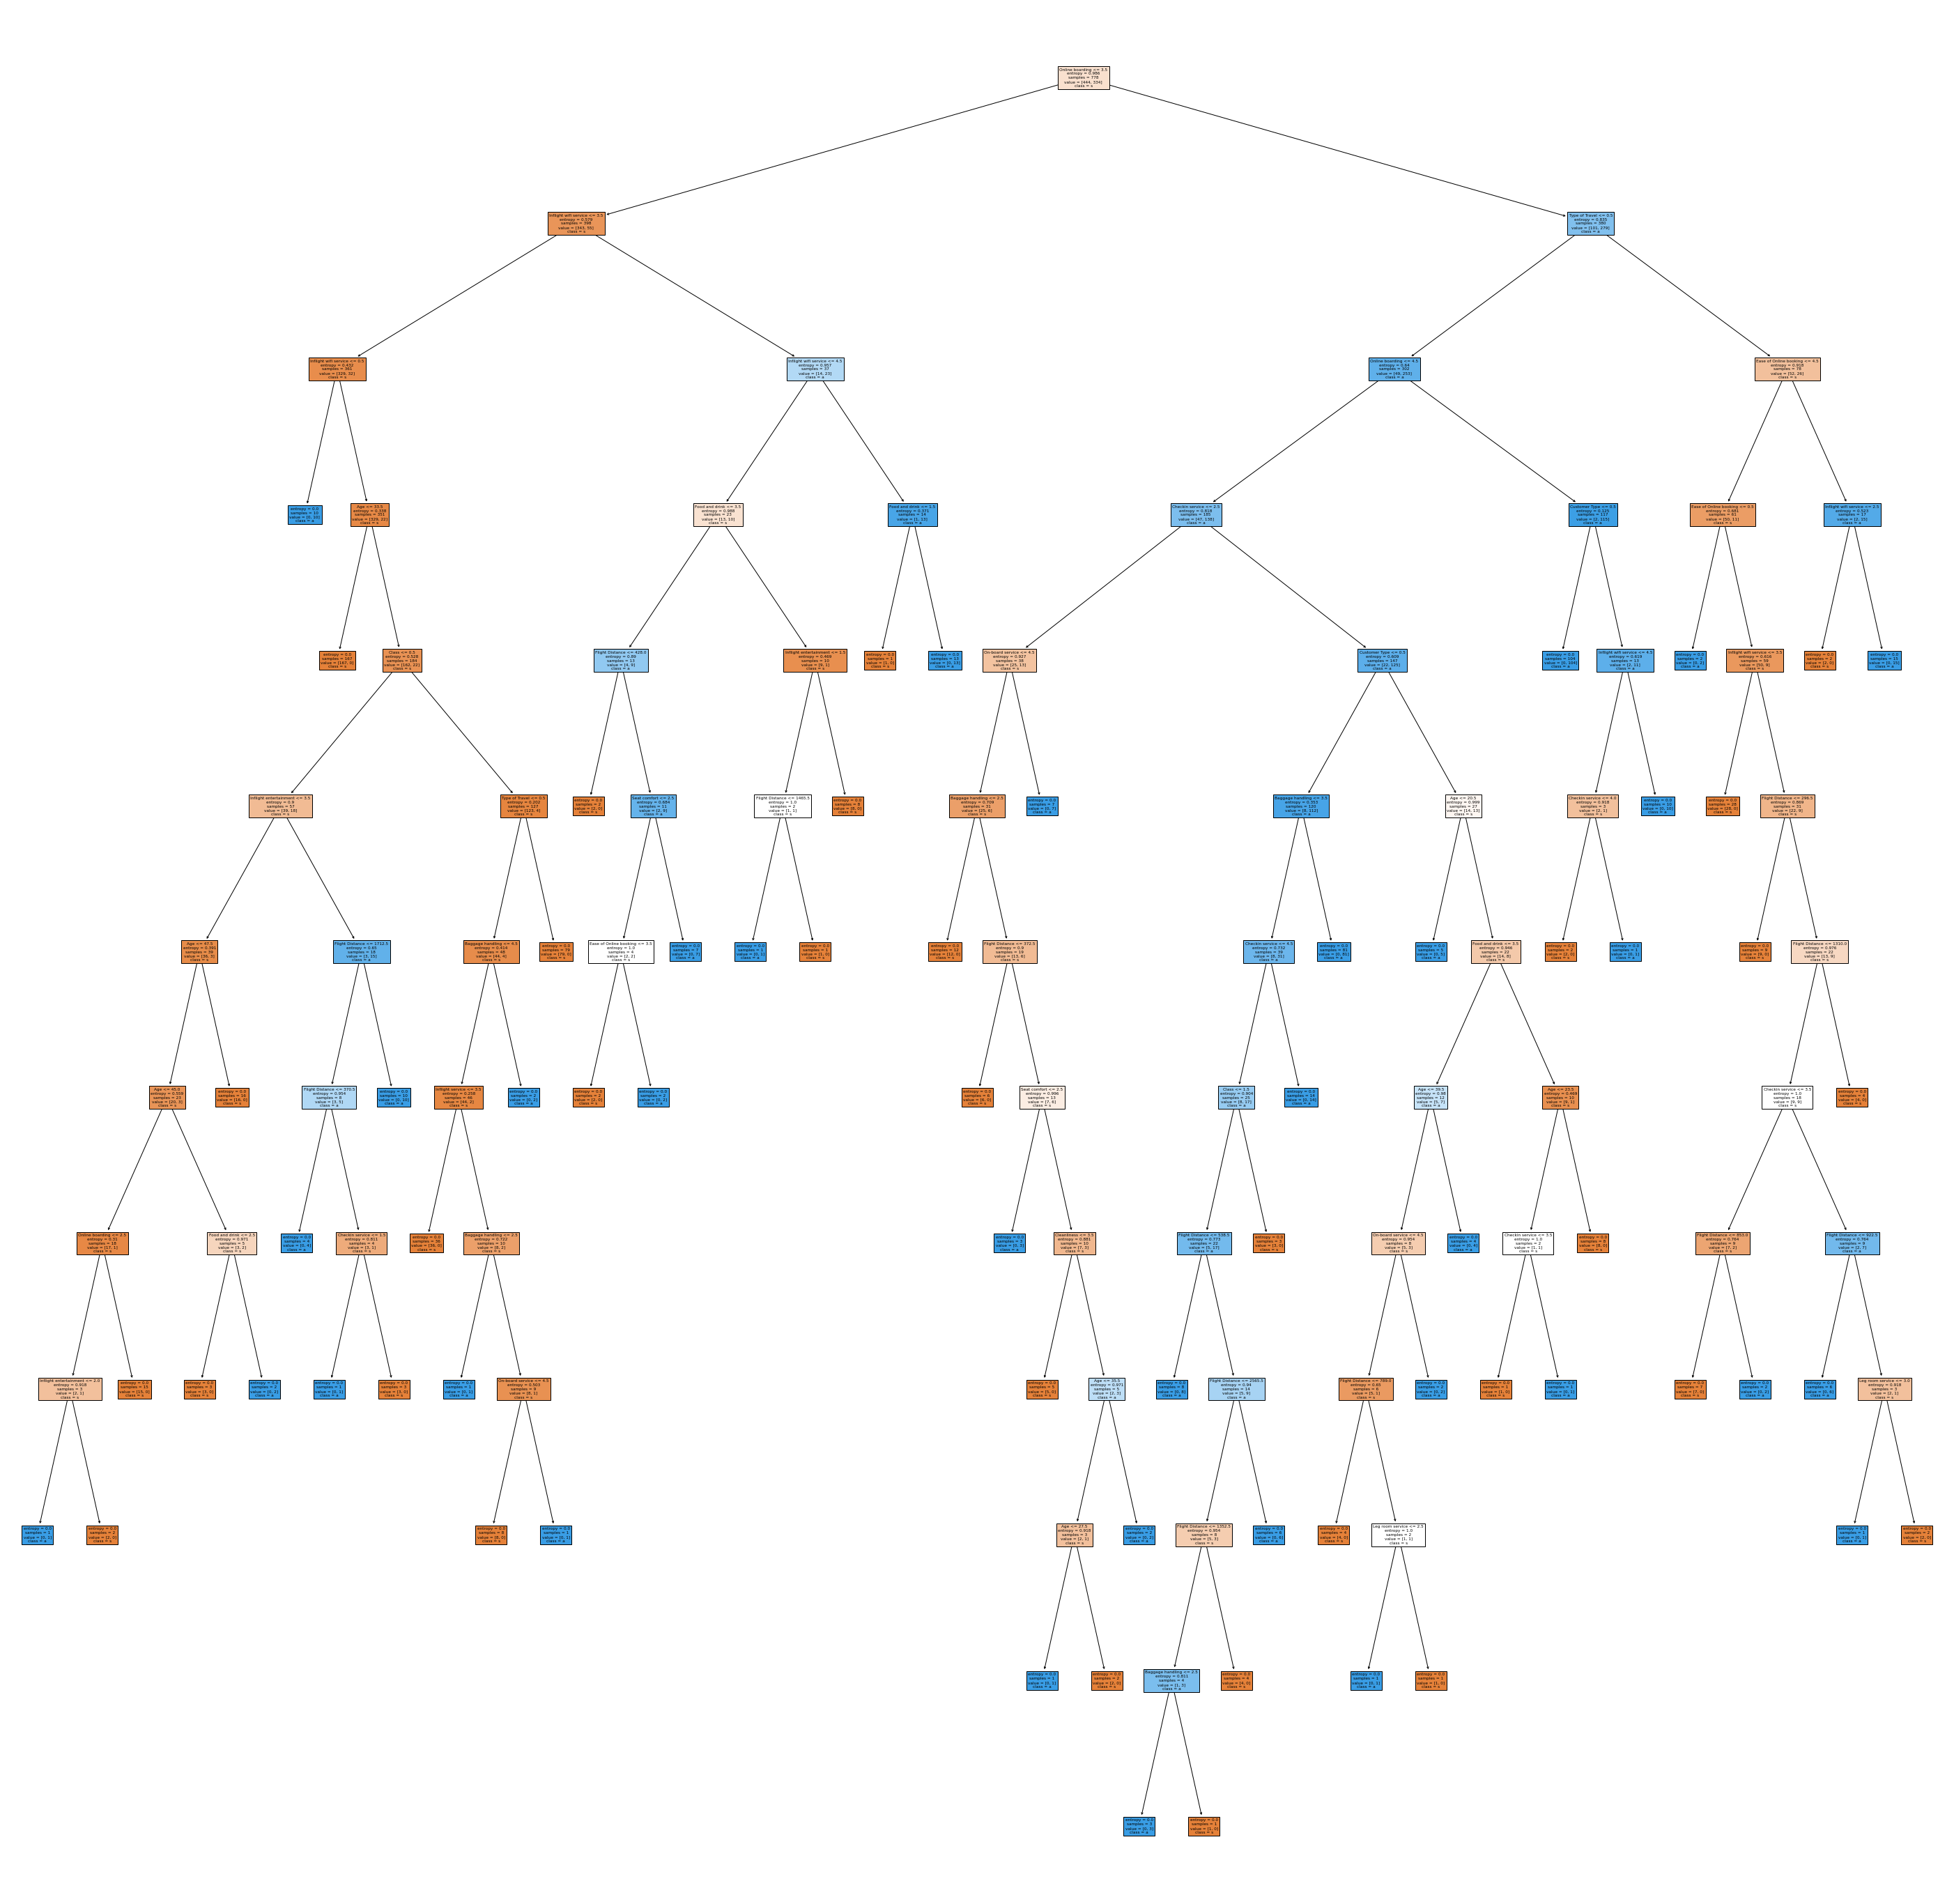

In [4]:
dtc = DecisionTreeClassifier(criterion='entropy', max_depth=None, min_samples_split=2, min_samples_leaf=1)
dtc.fit(features, klass)
plt.figure(figsize=[50, 50])
plot_tree(dtc, feature_names=feature_names, class_names=klass_names, filled=True)
plt.show

Fazemos, de seguida, os primeiros 2 passos, mas para a classe KNeighborsClassifier. Como esta classe não tem um atributo tree, não terá uma representação visual.

In [5]:
clf = KNeighborsClassifier(n_neighbors=1)
clf.fit(features, klass)


KNeighborsClassifier(n_neighbors=1)

Através do método predict(), é possível fazer previsões de qual a classe um conjunto de utilizadores, ao passar os seus dados. Como temos acesso a um conjunto de dados com as suas classes, podemos testar a funcionalidade das árvores através deste método, utilizando os mesmos dados que foram usados para criar as árvores. Com auxílio do método percentage_right(), podemos ver a percentagem de clientes cuja predição estava correta.

In [6]:
def percentage_right(pre, ori):
    acc = 0
    for i in range(1, len(pre)):
        if pre[i] == ori[i]:
            acc += 1
    return 100 * acc / len(pre)

percentage_right(dtc.predict(features), klass)

99.87146529562982

In [7]:
percentage_right(clf.predict(features), klass)

99.87146529562982

Podemos ver que ambos os modelos predizem bem os dados que foram dados, com apenas um cliente cujas avaliações não são preditas por ambos os modelos.

No entanto, este método não chega para avaliar os modelos e retirar conclusões concretas. Existe, no entanto, o método cross_val_score, que avalia por cross-validation. Esta técnica consiste numa divisão do conjunto de dados em k subconjuntos. Um subconjunto é escolhido para para testar o modelo, depois de ser treinado a partir do anterior. Este processo é repetido k vezes, para que cada subconjunto seja utilizado para testar.

In [8]:
dtc = DecisionTreeClassifier(criterion='entropy', max_depth=None, min_samples_split=2, min_samples_leaf=1)
scores1 = cross_val_score(dtc, X=features, y=klass, cv=10, n_jobs=-1)
scores1

array([0.80769231, 0.91025641, 0.8974359 , 0.91025641, 0.92307692,
       0.8974359 , 0.8974359 , 0.84615385, 0.90909091, 0.93506494])

In [9]:
clf = KNeighborsClassifier(n_neighbors=1)
scores2 = cross_val_score(clf, X=features, y=klass, cv=10, n_jobs=-1)
scores2

array([0.53846154, 0.53846154, 0.57692308, 0.69230769, 0.69230769,
       0.66666667, 0.51282051, 0.62820513, 0.5974026 , 0.54545455])

Podemos também organizar estes valores, de forma a ter a sua média e desvio padrão, de forma a melhor analisar.

In [10]:
print(numpy.mean(scores1), "+/-", numpy.std(scores1))
print(numpy.mean(scores2), "+/-", numpy.std(scores2))

0.8933899433899434 +/- 0.03613591054033723
0.5989010989010989 +/- 0.06399847104114673


Para chegar a estes valores, foi necessário escolher valores para os argumentos das 2 classes, nomeadamente max_depth, min_samples_split, min_samples_leaf e n_neighbors. Sendo assim, o último passo é verificar quais os melhores valores para estes argumentos. Para os escolher, verificámos várias combinações destes valores.

In [11]:
def my_sort(first, second, third):
    return zip(*sorted(zip(first, second, third)))

criteria = ["min_samples_split", "min_samples_leaf", "max_depth_tree"]
values = []
means = []
deviations = []
for min_samples_split in range(2, 20):
    for min_samples_leaf in range(1, 20):
        for max_depth_tree in range(0, 20):
            dtc = DecisionTreeClassifier(criterion='entropy',
                                         max_depth=None if max_depth_tree == 0 else max_depth_tree,
                                         min_samples_split=min_samples_split,
                                         min_samples_leaf=min_samples_leaf)
            scores = cross_val_score(dtc, X=features, y=klass, cv=10, n_jobs=-1)
            values += [[min_samples_split, min_samples_leaf, max_depth_tree]]
            means += [numpy.mean(scores)]
            deviations += [numpy.std(scores)]

means, values, deviations = my_sort(means, values, deviations)
# write_to_file("tree.txt", criteria, values, means, deviations)

print("Top 3 for DTC")
for i in range(len(means)-3, len(means)):
    print("Criteria:")
    for j in range(len(criteria)):
        print("--", criteria[j], values[i][j])
    print("Score:")
    print("--", means[i], "+/-", deviations[i])
print("\n")

criteria = ["n_neighbors"]
values = []
means = []
deviations = []

for n_neighbors in range(1, 20):
    clf = KNeighborsClassifier(n_neighbors=n_neighbors)
    scores = cross_val_score(clf, X=features, y=klass, cv=10, n_jobs=-1)
    values += [[n_neighbors]]
    means += [numpy.mean(scores)]
    deviations += [numpy.std(scores)]

means, values, deviations = my_sort(means, values, deviations)
# write_to_file("knei.txt", criteria, values, means, deviations)



print("Top 3 for CLF")
for i in range(len(means)-3, len(means)):
    print("Criteria:")
    for j in range(len(criteria)):
        print("--", criteria[j], values[i][j])
    print("Score:")
    print("--", means[i], "+/-", deviations[i])
print("\n")

Top 3 for DTC
Criteria:
-- min_samples_split 4
-- min_samples_leaf 2
-- max_depth_tree 17
Score:
-- 0.9048618048618048 +/- 0.038186819539009986
Criteria:
-- min_samples_split 3
-- min_samples_leaf 1
-- max_depth_tree 9
Score:
-- 0.9049617049617049 +/- 0.04010088675541514
Criteria:
-- min_samples_split 13
-- min_samples_leaf 1
-- max_depth_tree 6
Score:
-- 0.9061771561771561 +/- 0.041511683807701205


Top 3 for CLF
Criteria:
-- n_neighbors 16
Score:
-- 0.6568931068931068 +/- 0.027162913911610197
Criteria:
-- n_neighbors 17
Score:
-- 0.6568931068931069 +/- 0.025299485256616745
Criteria:
-- n_neighbors 18
Score:
-- 0.6595071595071594 +/- 0.0393015875172749




A partir de uma análise aos resultados, chegámos a algumas conclusões. Primeiro, a DTC é muito melhor a fazer predição que a CLF (subida de por volta de 60% para 80 a 90%). Segundo, quanto aos valores a passar à DTC, a min_samples_leaf a 1 e uma max_depth_tree maior ou igual a 6 eram presentes em todas a k avaliações. O valor do min_samples_split não era muito importante para a percentagem de valores corretos, no entanto, os valores mais baixo levavam a uma menor _standard deviation_. A max_depth_tree deve ser maior ou igual a 6, no entanto, não identificámos que um valor muito mais elevado fosse uma vantagem. A partir desta análise, escolhemos, então, os valores para passar à DTC, fizemos a predição com base nos valores de teste, e guardámos os resultador em results.csv.

De notar que os resultados obtidos neste relatório terão algumas diferenças comparativamente aos resultados obtidos nos testes feitos anteriormente, pelo que os valores escolhidos poderão não ser um dos conjuntos de valores do top 3 anterior. Isto deve-se à variação natural que ocorre ao testar estes dados, que depende da forma que o cross_val_score() dividir os dados.

In [42]:
dtc = DecisionTreeClassifier(criterion='entropy',
                             max_depth=10,
                             min_samples_split=3,
                             min_samples_leaf=1)
dtc.fit(features, klass)
scores = cross_val_score(dtc, X=features, y=klass, cv=10, n_jobs=-1)
print(numpy.mean(scores), "+/-", numpy.std(scores))
prediction = dtc.predict(test_features)
save_data("results.csv", prediction)


0.9061938061938062 +/- 0.027484654080989733
